# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [7]:
pip install keras-tuner --trusted-host pypi.org --trusted-host files.pythonhosted.org


Note: you may need to restart the kernel to use updated packages.


In [8]:
# Import libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [12]:
def get_file_list(base_path) :
  """
  Returns the list of files present in the base_path
  """
  file_list = []
  for dirname, _, filenames in os.walk(base_path):
      for filename in filenames:
          file_list.append(os.path.join(dirname, filename))

  return file_list



def get_stock_name_from_filename(filepath):
  """
  Returns the Stock name from filename
  """
  filename = filepath.split('/')[-1]
  return filename.split('_')[0]


def rename_column_names_for_number_type(df, stock_name):
  """
  Renames the column names by appending the stock name to it
  """
  numeric_cols =  df.select_dtypes(include='number').columns
  df_renamed = df.rename(columns={col: f"{col}_{stock_name}" for col in numeric_cols})
  return df_renamed


def get_aggregated_df_from_files(base_path):
  """
  Returns the aggregated Dataframe by reading all files
  """

  aggregated_df = pd.DataFrame()

  file_list = get_file_list(base_path)

  for filename in file_list:
    stock_name = get_stock_name_from_filename(filename)

    df = pd.read_csv(filename).drop('Name', axis=1)
    df = rename_column_names_for_number_type(df, stock_name)

    if aggregated_df.empty:
        aggregated_df = df
    else:
        aggregated_df = pd.merge(aggregated_df, df, on='Date', how='outer')

  return aggregated_df


def get_unique_stock_names(base_path):
  """
  Returns the list of unique stock names
  """
  unique_stock_names =[]
  for i in get_file_list(base_path):
    unique_stock_names.append(get_stock_name_from_filename(i))

  return unique_stock_names


def get_stock_related_columns(df, stock_name):
  """
  Returns the columns related to the stock name
  """
  columns = [col for col in df.columns if col.endswith(stock_name)]

  selected_columns = ['Date'] + columns

  return df[selected_columns]


In [13]:
base_path = 'data'

unique_stock_names = get_unique_stock_names(base_path)
unique_stock_names

['AMZN', 'IBM', 'MSFT', 'GOOGL']

In [14]:
# Define a function to load data and aggregate them

all_stocks_df = get_aggregated_df_from_files(base_path)
all_stocks_df.head()

,Date,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Volume_AMZN,Open_IBM,High_IBM,Low_IBM,Close_IBM,...,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Volume_MSFT,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL
0,2006-01-03,47.47,47.85,46.25,47.58,7582127.0,82.45,82.55,80.81,82.06,...,26.25,27.00,26.10,26.84,79974418.0,211.47,218.05,209.32,217.83,13137450.0
1,2006-01-04,47.48,47.73,46.69,47.25,7440914.0,82.20,82.50,81.33,81.95,...,26.77,27.08,26.77,26.97,57975661.0,222.17,224.70,220.09,222.84,15292353.0
2,2006-01-05,47.16,48.20,47.11,47.65,5417258.0,81.40,82.90,81.00,82.50,...,26.96,27.13,26.91,26.99,48247610.0,223.22,226.00,220.97,225.85,10815661.0
3,2006-01-06,47.97,48.58,47.32,47.87,6154285.0,83.95,85.03,83.41,84.95,...,26.89,27.00,26.49,26.91,100969092.0,228.66,235.49,226.85,233.06,17759521.0
4,2006-01-09,46.55,47.10,46.40,47.08,8945056.0,84.10,84.25,83.38,83.73,...,26.93,27.07,26.76,26.86,55627836.0,233.44,236.94,230.70,233.68,12795837.0


In [15]:
# View specifics of the data
all_stocks_df.shape


(3020, 21)

In [16]:
all_stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3020 non-null   object 
 1   Open_AMZN     3019 non-null   float64
 2   High_AMZN     3019 non-null   float64
 3   Low_AMZN      3019 non-null   float64
 4   Close_AMZN    3019 non-null   float64
 5   Volume_AMZN   3019 non-null   float64
 6   Open_IBM      3019 non-null   float64
 7   High_IBM      3020 non-null   float64
 8   Low_IBM       3019 non-null   float64
 9   Close_IBM     3020 non-null   float64
 10  Volume_IBM    3020 non-null   int64  
 11  Open_MSFT     3019 non-null   float64
 12  High_MSFT     3019 non-null   float64
 13  Low_MSFT      3019 non-null   float64
 14  Close_MSFT    3019 non-null   float64
 15  Volume_MSFT   3019 non-null   float64
 16  Open_GOOGL    3019 non-null   float64
 17  High_GOOGL    3019 non-null   float64
 18  Low_GOOGL     3019 non-null 

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [18]:
# Checking if there are any Null values
all_stocks_df.isnull().values.any()

True

In [19]:
# Handle Missing Values

all_stocks_df['Date'] = pd.to_datetime(all_stocks_df['Date'])
all_stocks_df = all_stocks_df.sort_values('Date')
all_stocks_df = all_stocks_df.fillna(method='ffill')

In [20]:
all_stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3020 non-null   datetime64[ns]
 1   Open_AMZN     3020 non-null   float64       
 2   High_AMZN     3020 non-null   float64       
 3   Low_AMZN      3020 non-null   float64       
 4   Close_AMZN    3020 non-null   float64       
 5   Volume_AMZN   3020 non-null   float64       
 6   Open_IBM      3020 non-null   float64       
 7   High_IBM      3020 non-null   float64       
 8   Low_IBM       3020 non-null   float64       
 9   Close_IBM     3020 non-null   float64       
 10  Volume_IBM    3020 non-null   int64         
 11  Open_MSFT     3020 non-null   float64       
 12  High_MSFT     3020 non-null   float64       
 13  Low_MSFT      3020 non-null   float64       
 14  Close_MSFT    3020 non-null   float64       
 15  Volume_MSFT   3020 non-null   float64 

In [21]:
all_stocks_df.isnull().values.any()

False

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

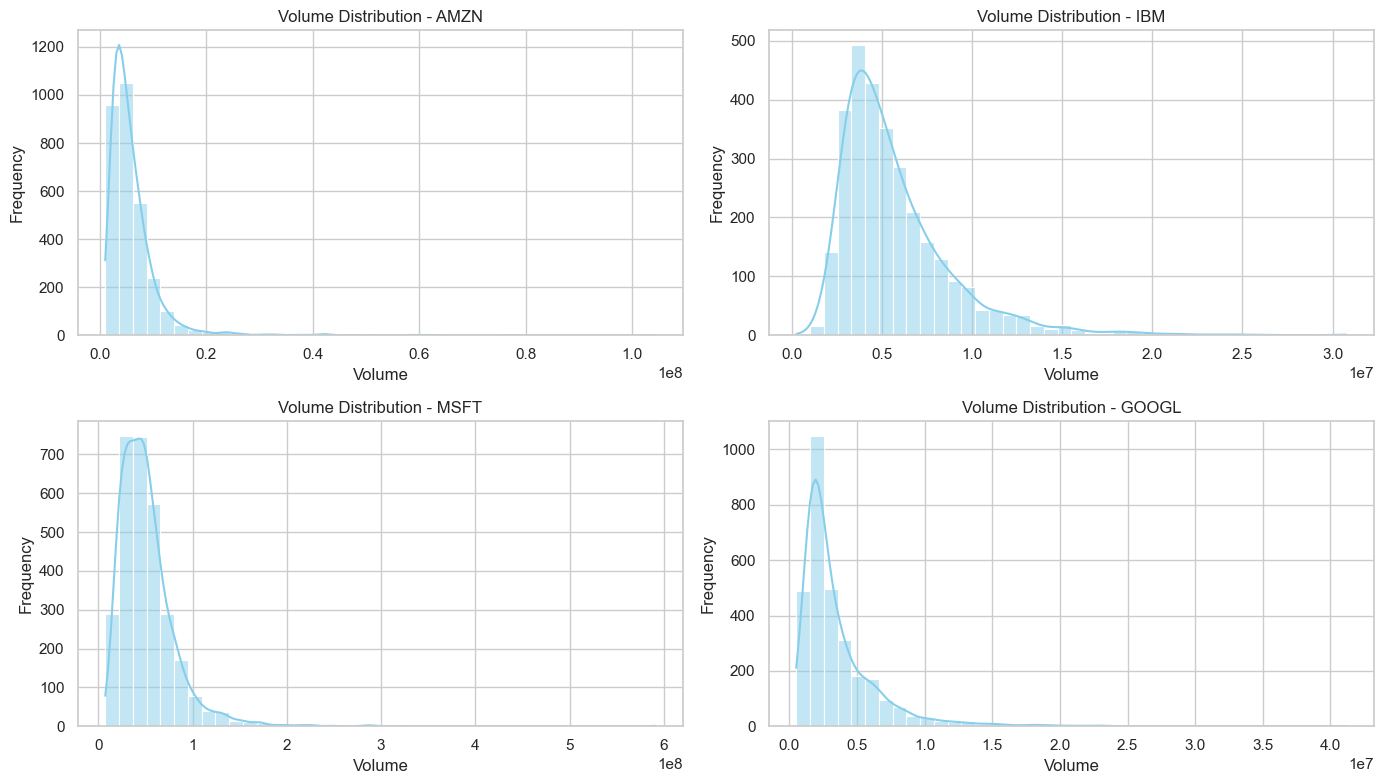

In [24]:
# Frequency distribution of volumes

stock_names = unique_stock_names
num_stocks = len(stock_names)

cols = 2
rows = (num_stocks + 1) // cols

plt.figure(figsize=(14, 4 * rows))
sns.set(style="whitegrid")

for index, stock in enumerate(stock_names, 1):
    plt.subplot(rows, cols, index)
    sns.histplot(
        data= get_stock_related_columns(all_stocks_df,stock),
        x=f'Volume_{stock}',
        bins=40,
        kde=True,
        color='skyblue'
    )
    plt.title(f'Volume Distribution - {stock}')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


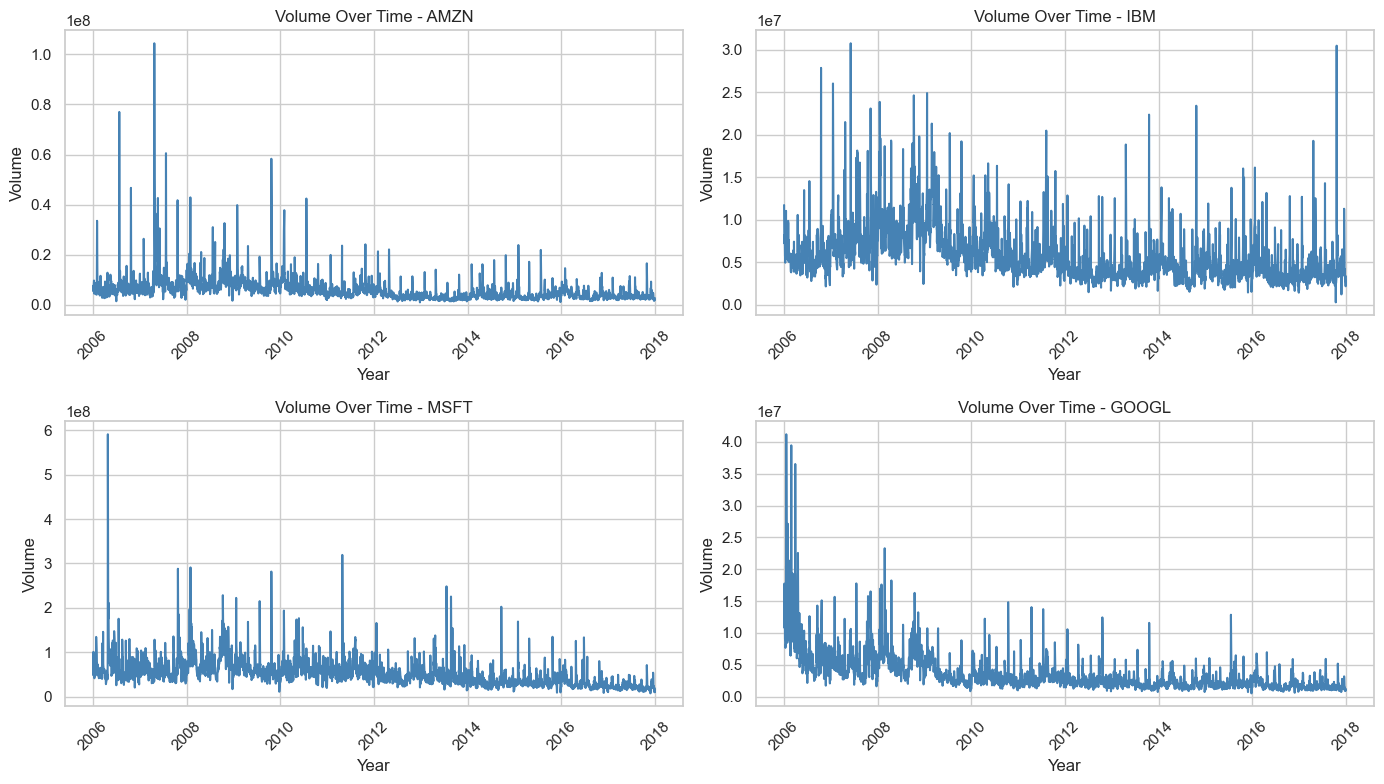

In [25]:
# Stock volume variation over time

all_stocks_df['Date'] = pd.to_datetime(all_stocks_df['Date'])

plt.figure(figsize=(14, 4 * rows))
sns.set(style="whitegrid")

for index, stock in enumerate(stock_names, 1):
    plt.subplot(rows, cols, index)
    df_stock = get_stock_related_columns(all_stocks_df,stock)

    sns.lineplot(data=df_stock, x='Date', y=f'Volume_{stock}', color='steelblue')
    plt.title(f'Volume Over Time - {stock}')
    plt.xlabel('Year')
    plt.ylabel('Volume')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



### Remarks:

*    IBM plot depicts that in the year 2008 to 2010 consumers have purchased huge amount of stocks
*    In the year 2006, there is peak in purchasing of GOOGLE stocks.
*    For AMAZON and MICROSOFT, consumers have invested consistently over year 2006 to 2010.

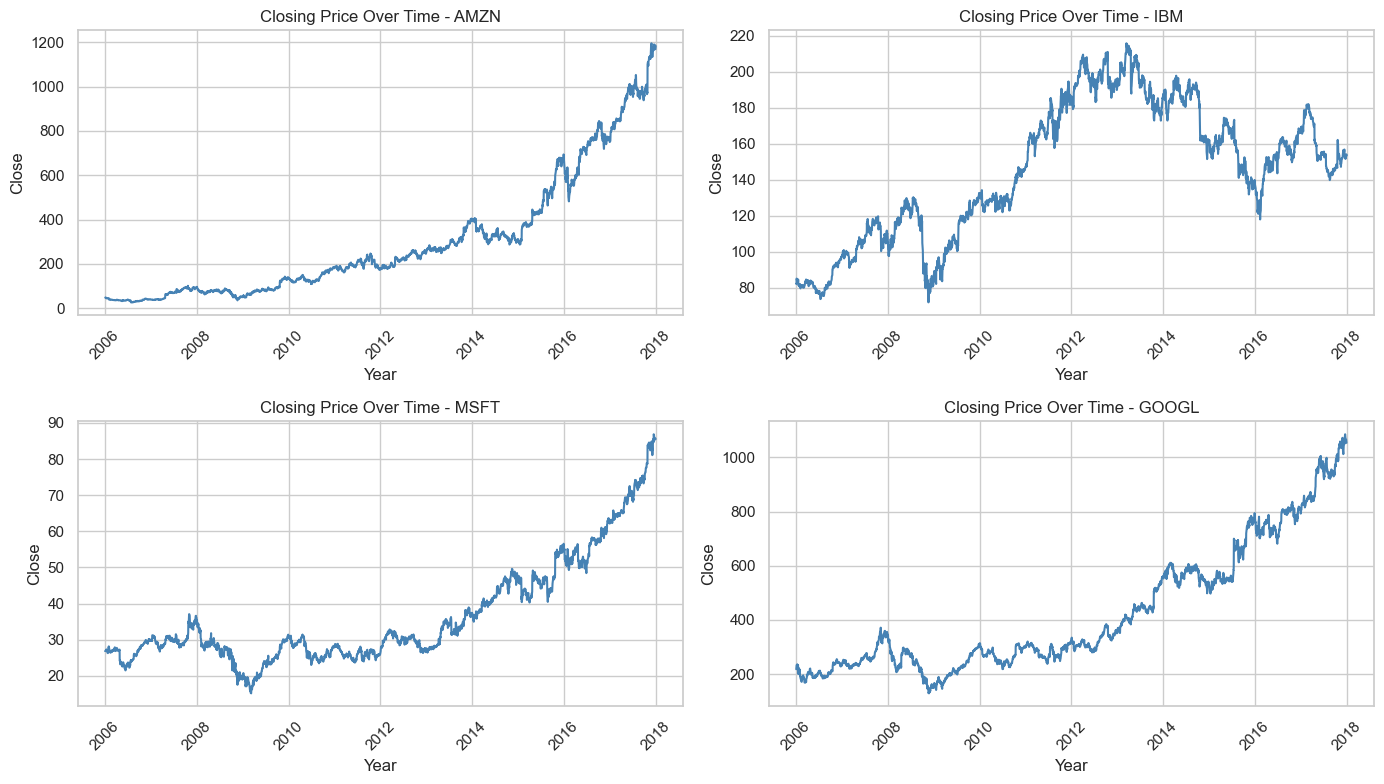

In [27]:
# Stock price variation over time

plt.figure(figsize=(14, 4 * rows))
sns.set(style="whitegrid")

for index, stock in enumerate(stock_names, 1):
    plt.subplot(rows, cols, index)
    df_stock = get_stock_related_columns(all_stocks_df,stock)

    sns.lineplot(data=df_stock, x='Date', y=f'Close_{stock}', color='steelblue')
    plt.title(f'Closing Price Over Time - {stock}')
    plt.xlabel('Year')
    plt.ylabel('Close')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Remarks:
*    The stock price of AMAZON, GOOGLE and MICROSOFT  have consistently increased over the time. 
*    The IBM stock price has increased till 2013 but post that there is volatility and no consistency.

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

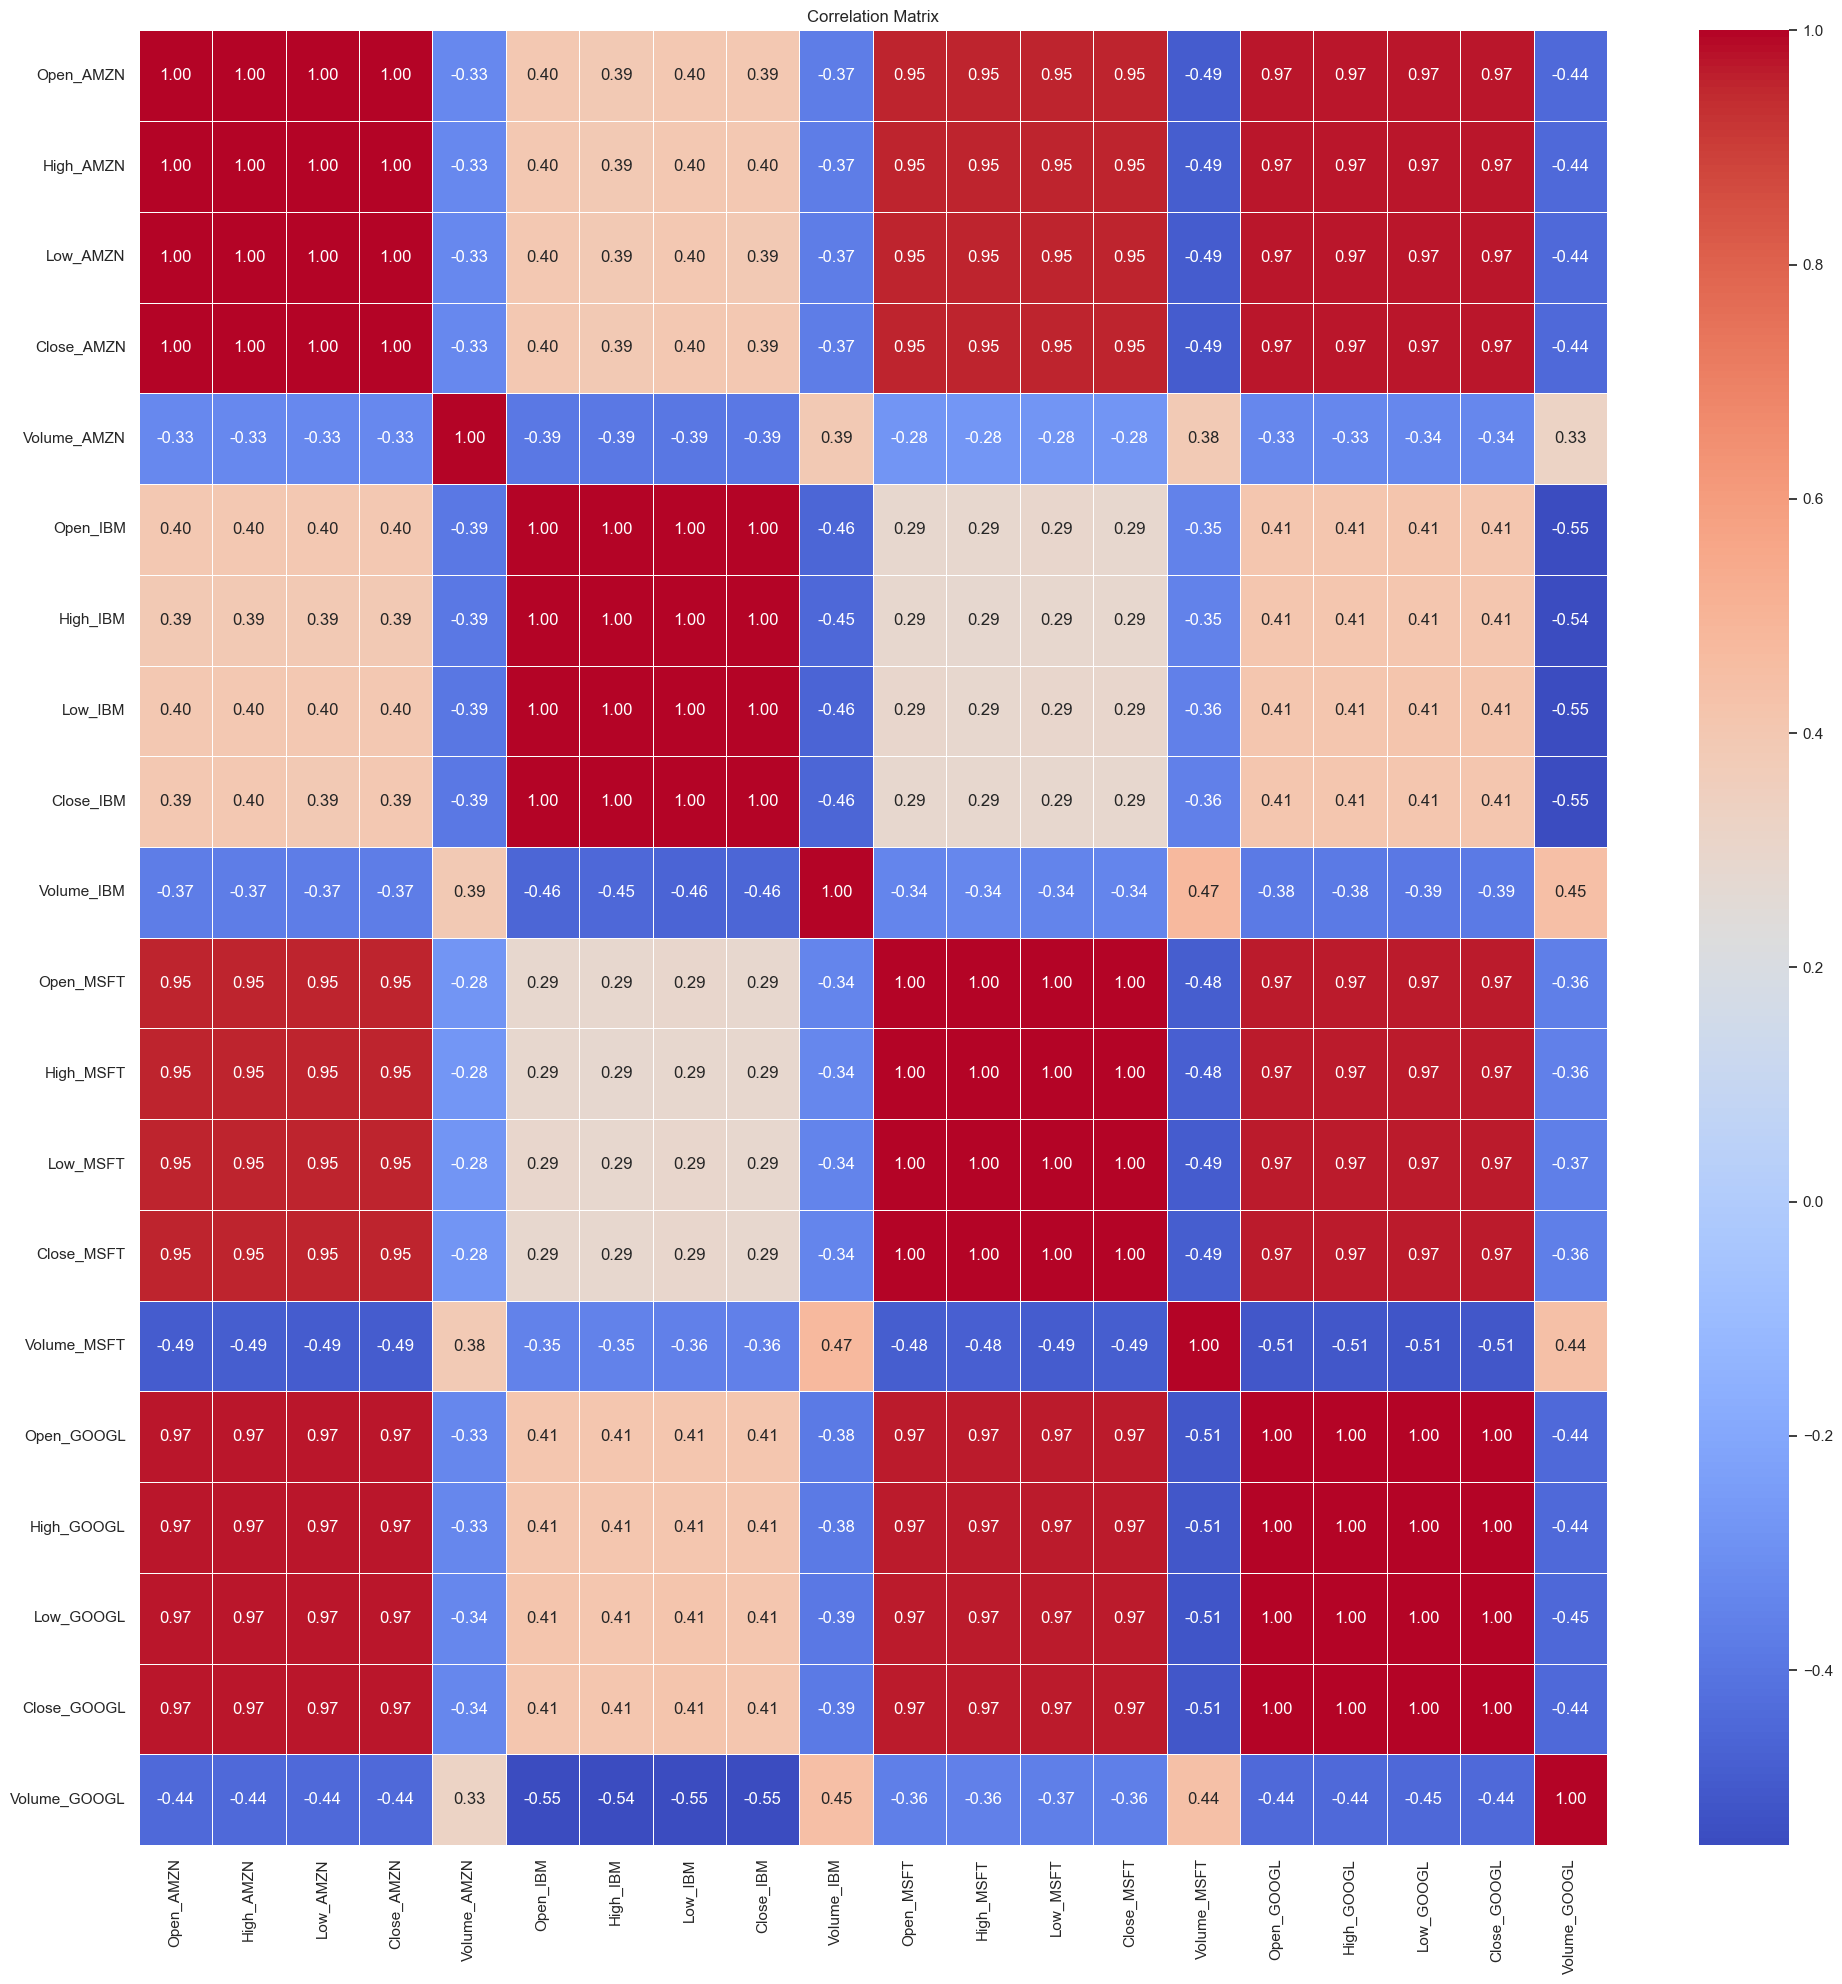

In [30]:
plt.figure(figsize=(20,10 * rows))
sns.set(style="whitegrid")

corr_matrix = all_stocks_df.select_dtypes(include='number').corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.6)
plt.title(f"Correlation Matrix")
plt.tight_layout()
plt.show()

#### There is high correlation between columns OPEN, CLOSE, HIGH and LOW. Hence we will be considering only CLOSE (closing price) of the stock data and dropping others.

In [32]:
corr_columns = []

for stock in ['AMZN', 'GOOGL', 'MSFT', 'IBM']:
  for col in ['Open', 'High', 'Low']:
    corr_columns.append(f"{col}_{stock}")

all_stocks_df = all_stocks_df.drop(corr_columns, axis=1)
all_stocks_df.head()

,Date,Close_AMZN,Volume_AMZN,Close_IBM,Volume_IBM,Close_MSFT,Volume_MSFT,Close_GOOGL,Volume_GOOGL
0,2006-01-03,47.58,7582127.0,82.06,11715200,26.84,79974418.0,217.83,13137450.0
1,2006-01-04,47.25,7440914.0,81.95,9840600,26.97,57975661.0,222.84,15292353.0
2,2006-01-05,47.65,5417258.0,82.50,7213500,26.99,48247610.0,225.85,10815661.0
3,2006-01-06,47.87,6154285.0,84.95,8197400,26.91,100969092.0,233.06,17759521.0
4,2006-01-09,47.08,8945056.0,83.73,6858200,26.86,55627836.0,233.68,12795837.0


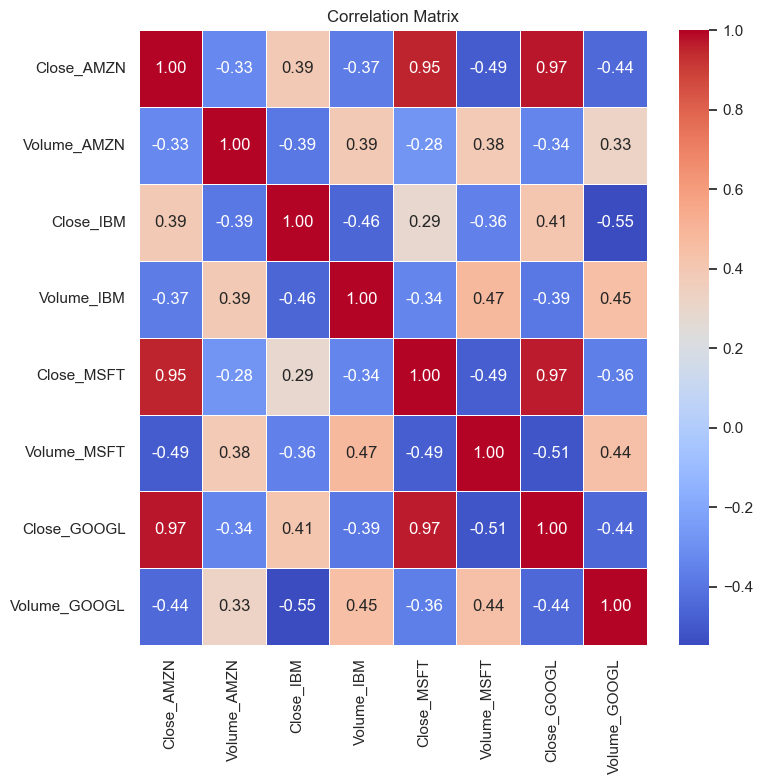

In [33]:
plt.figure(figsize=(8,4 * rows))
sns.set(style="whitegrid")

corr_matrix = all_stocks_df.select_dtypes(include='number').corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.6)
plt.title(f"Correlation Matrix")


plt.tight_layout()
plt.show()

In [34]:
all_stocks_df.head()

,Date,Close_AMZN,Volume_AMZN,Close_IBM,Volume_IBM,Close_MSFT,Volume_MSFT,Close_GOOGL,Volume_GOOGL
0,2006-01-03,47.58,7582127.0,82.06,11715200,26.84,79974418.0,217.83,13137450.0
1,2006-01-04,47.25,7440914.0,81.95,9840600,26.97,57975661.0,222.84,15292353.0
2,2006-01-05,47.65,5417258.0,82.50,7213500,26.99,48247610.0,225.85,10815661.0
3,2006-01-06,47.87,6154285.0,84.95,8197400,26.91,100969092.0,233.06,17759521.0
4,2006-01-09,47.08,8945056.0,83.73,6858200,26.86,55627836.0,233.68,12795837.0


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [40]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windowed_df_list(df, window_size=3, step_size=1, target_names=None):
    """
    Generate windowed dataframes (X and y) from a stock dataset for multiple target stocks.
    """

    if target_names is None:
        raise ValueError("target_names list must be provided.")

    X_windows = []
    y_targets = []

    # Processing each stock separately
    for stock in target_names:
        df_stock = df.sort_values(by='Date').reset_index(drop=True)

        # Loop through the stock data with sliding windows
        for start in range(0, len(df_stock) - window_size, step_size):
            end = start + window_size

            X_window = df_stock.iloc[start:end][[f'Close_{stock}']].copy()
            y_target = df_stock.iloc[end][f'Close_{stock}'] if end < len(df_stock) else None

            if y_target is not None:
                X_windows.append(X_window)
                y_targets.append(y_target)

    return X_windows, y_targets

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [43]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_dataframes(X_windows, y_targets):
    """
    Scales a list of windowed DataFrames using partial_fit to avoid data leakage.

    """
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    #Using partial_fit to accumulate statistics across all windows
    for window in X_windows:
        X_scaler.partial_fit(window)

    for y in y_targets:
        y_scaler.partial_fit(np.array([[y]]))

    # Now, transform each window and target
    X_scaled_list = [X_scaler.transform(window) for window in X_windows]
    y_scaled = y_scaler.transform(np.array(y_targets).reshape(-1, 1)).flatten()

    return X_scaled_list, y_scaled, X_scaler, y_scaler



Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [47]:
# Define a function to create input and output data points from the master DataFrame

def prepare_rnn_dataset(df, target_names, window_size=3, step_size=1, train_ratio=0.8):
    """
    Main function to prepare windowed, scaled, train/test-split RNN-ready data.

    """
    # Create windowed DataFrames
    X_windows, y_targets = create_windowed_df_list(
        df,
        window_size=window_size,
        step_size=step_size,
        target_names=target_names
    )

    # Scale them using partial_fit
    X_scaled_list, y_scaled,X_scaler, y_scaler = scale_windowed_dataframes(X_windows, y_targets)

    #Convert list of arrays to single 3D array for RNN
    X_all = np.array(X_scaled_list)
    y_all = np.array(y_scaled)

    #Train-test split (time-based)
    split_index = int(len(X_all) * train_ratio)
    X_train, X_test = X_all[:split_index], X_all[split_index:]
    y_train, y_test = y_all[:split_index], y_all[split_index:]

    return X_train, y_train, X_test, y_test, X_scaler, y_scaler



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [51]:
# Checking for patterns in different sequence lengths

def plot_temporal_aggregation(df, stock_name):
    df_stock = df.copy()
    df_stock.set_index('Date', inplace=True)

    # Resample for weekly, monthly, quarterly
    weekly = df_stock[f'Close_{stock_name}'].resample('W').mean()
    monthly = df_stock[f'Close_{stock_name}'].resample('M').mean()
    quarterly = df_stock[f'Close_{stock_name}'].resample('Q').mean()

    plt.figure(figsize=(16, 8))

    plt.subplot(3, 1, 1)
    plt.plot(weekly, label='Weekly Avg')
    plt.title(f'{stock_name} Weekly Close Price')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(monthly, label='Monthly Avg', color='orange')
    plt.title(f'{stock_name} Monthly Close Price')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(quarterly, label='Quarterly Avg', color='green')
    plt.title(f'{stock_name} Quarterly Close Price')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


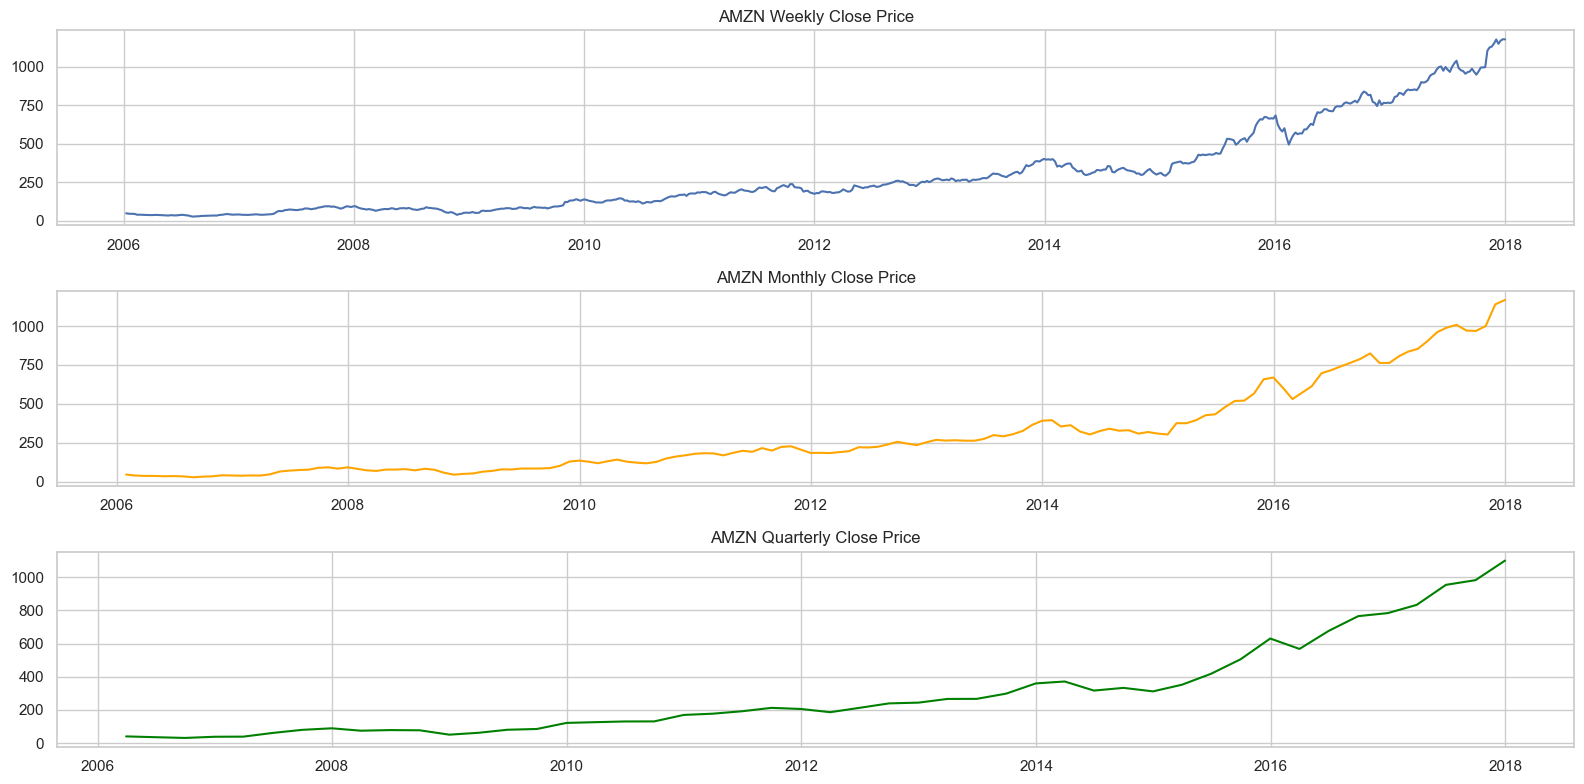

In [52]:
plot_temporal_aggregation(all_stocks_df, 'AMZN')

 ### Remarks from AMZN closing prices over time:

Weekly averages show high volatility with many small fluctuations.

*   There is high volatility with many small fluctuations in Weekly plot
*   Monthly averages smooth the curve slightly, but you can still observe trends developing.
*   There is clear long-term trends and reduce noise effectively in Quarterly plot.

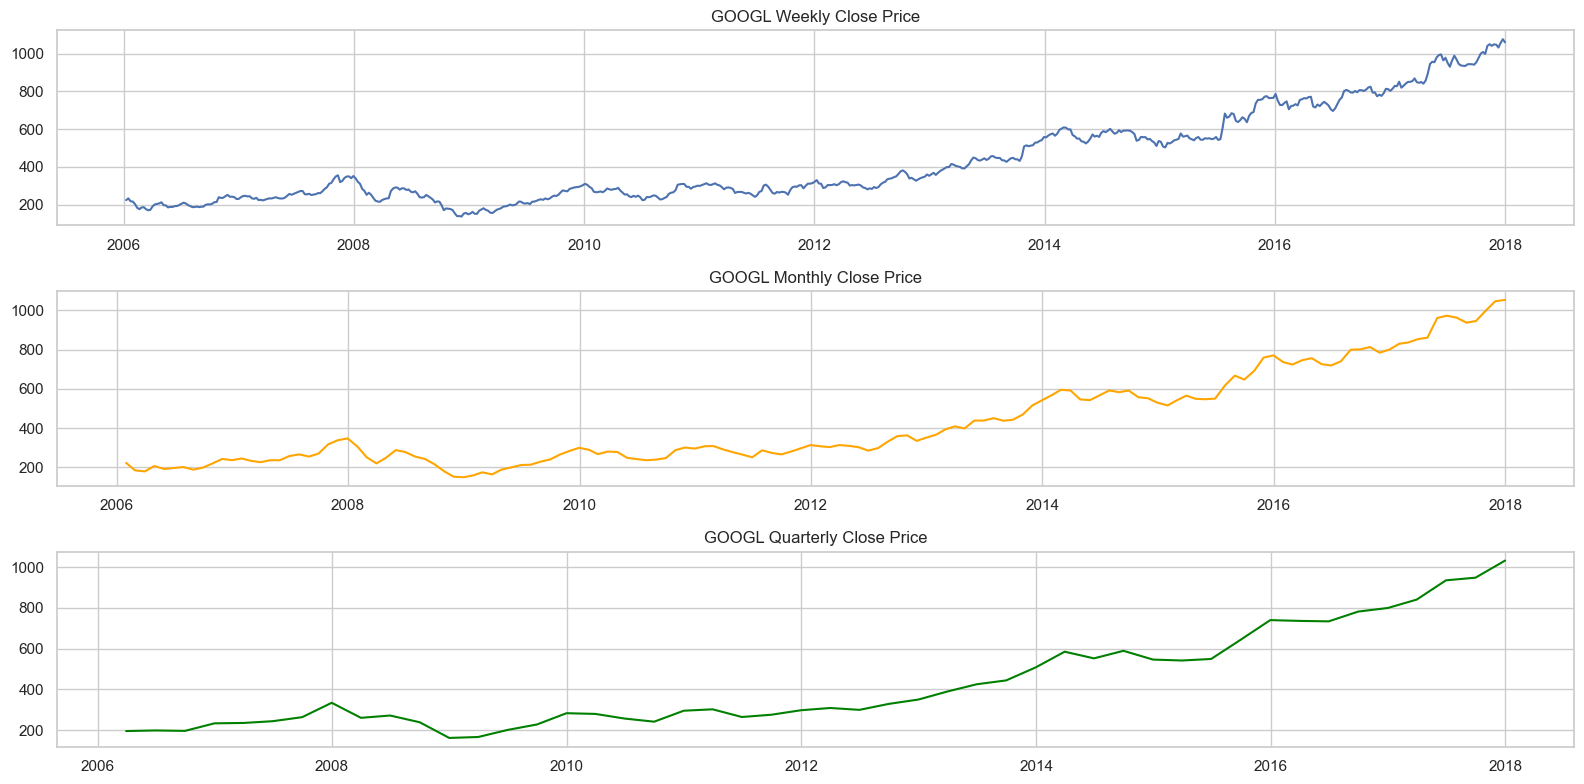

In [54]:
plot_temporal_aggregation(all_stocks_df, 'GOOGL')

### Remarks on Google closing price plot:
*    Here also Weekly plot shows noisy and volatile trend
*    Monthly plot shows clear upward and downward trend
*    Quarterly plot shows sustained directional trends.

## Window size of 20(monthly) is good choice with Step Size 1.
As we saw for GOOGL and AMZN plots, there is a trend which repeats on the monthly basis. It avoids noises.

Also we will consider Step size = 1, as the data size is less.

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [58]:
# Create data instances from the master data frame using decided window size and window stride
# Executing RNN for GOOGLE stock

X_train, y_train, X_test, y_test, X_scaler, y_scaler = prepare_rnn_dataset(
    get_stock_related_columns(all_stocks_df,'GOOGL'),
    ['GOOGL'],
    window_size=20,
    step_size=1,
    train_ratio=0.8
)

In [59]:
# Check the number of data points generated
len(X_train)

2400

**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [61]:
# Check if the datasets are compatible inputs to neural networks

def check_rnn_input(x, y):
    assert isinstance(x, np.ndarray), "x is not a numpy array"
    assert len(x.shape) == 3, "x must be 3D: (samples, timesteps, features)"
    assert x.shape[0] == y.shape[0], "x and y sample counts do not match"
    assert not np.isnan(x).any(), "x contains NaNs"
    assert not np.isinf(x).any(), "x contains Infs"
    print("✅ Input data is RNN-ready!")

check_rnn_input(X_train, y_train)

✅ Input data is RNN-ready!


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

In [150]:
def print_model_evaluation_metrics(model, X_test, y_test, y_pred):
    model.summary()
    loss = model.evaluate(X_test, y_test)
    print()
    print(f"Test Loss (MSE): {loss}")
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")


def plot_actual_vs_predicted(y_test, y_pred, y_scaler):
    y_pred_inv = y_scaler.inverse_transform(y_pred)
    y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title('Actual vs Predicted Prices')
    plt.legend()
    plt.show()

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [67]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_simple_rnn_model(input_shape, rnn_units=50, learning_rate=0.001, dropout_rate =0.1):
    """
    Creates and compiles a simple RNN model.
    """
    model = Sequential()

    model.add(SimpleRNN(units=rnn_units, input_shape=input_shape, activation= 'tanh'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model




In [68]:
def build_evaluate_rnn_model(df, stock_name, window_size = 20, step_size =1, train_ratio=0.8, 
                            batch_size = 32, epoch_num=10, rnn_units=50, 
                            learning_rate=0.001, dropout_rate =0.1):
        
    X_train, y_train, X_test, y_test, X_scaler, y_scaler = prepare_rnn_dataset(
        get_stock_related_columns(all_stocks_df, stock_name),
        [stock_name],
        window_size= window_size,
        step_size=step_size,
        train_ratio=train_ratio
    )
    
    input_shape  = (X_train.shape[1], X_train.shape[2])
    simple_rnn_model = create_simple_rnn_model(input_shape, rnn_units, learning_rate, dropout_rate)

    early_stop = EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights = True)
    
    # Train the model
    simple_rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= epoch_num, 
                         batch_size=batch_size, callbacks = [early_stop])
    
    print('==================================================================================')
    print()
    
    y_pred_simple = simple_rnn_model.predict(X_test)
    print_model_evaluation_metrics(simple_rnn_model, X_test, y_test, y_pred_simple)
    
    plot_actual_vs_predicted(y_test, y_pred_simple, y_scaler)

#### Simple RNN model for GOOGLE

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2100 - val_loss: 0.5267
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.3748
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.3361
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.2727
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - val_loss: 0.2306
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 0.1838
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - val_loss: 0.1786
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.1525
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.1137
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.1060

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,955 (31.08 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,304 (20.72 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.0340

Test Loss (MSE): 0.10600943118333817
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
MSE: 0.1060
RMSE: 0.3256
R² Score: 0.5310


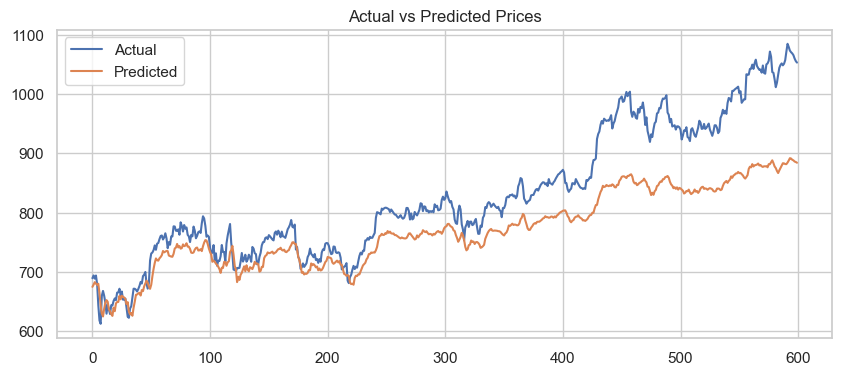

In [174]:
build_evaluate_rnn_model(all_stocks_df, 'GOOGL', window_size = 20, step_size =1, 
                         train_ratio=0.8, batch_size = 32, epoch_num=10)

#### Simple RNN model for MSFT

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3678 - val_loss: 1.2235
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.9081
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.7159
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.5699
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - val_loss: 0.4757
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.4120
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0048 - val_loss: 0.3571
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.2988
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 0.2802
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - val_loss: 0.2586
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.2439
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_lo

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,955 (31.08 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,304 (20.72 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0278

Test Loss (MSE): 0.12423738837242126
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
MSE: 0.1242
RMSE: 0.3525
R² Score: 0.7675


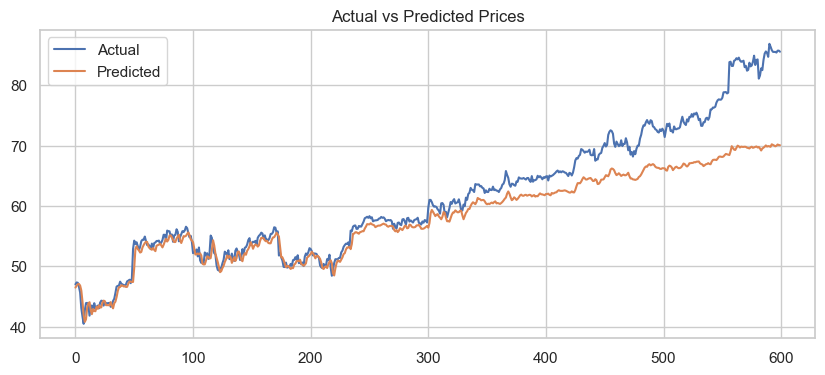

In [176]:
build_evaluate_rnn_model(all_stocks_df, 'MSFT', window_size = 20, step_size =1, 
                         train_ratio=0.8, batch_size = 32, epoch_num=20)

#### Simple RNN model for IBM

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4260 - val_loss: 0.0136
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 - val_loss: 0.0098
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - val_loss: 0.0067
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - val_loss: 0.0052
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - val_loss: 0.0051
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0043
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0047
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 - val_loss: 0.0040
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102 - val_loss: 0.0038
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - val_loss: 0.0036
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - val_loss: 0.0037
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - val_lo

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,955 (31.08 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,304 (20.72 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039

Test Loss (MSE): 0.0031408481299877167
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
MSE: 0.0031
RMSE: 0.0560
R² Score: 0.9714


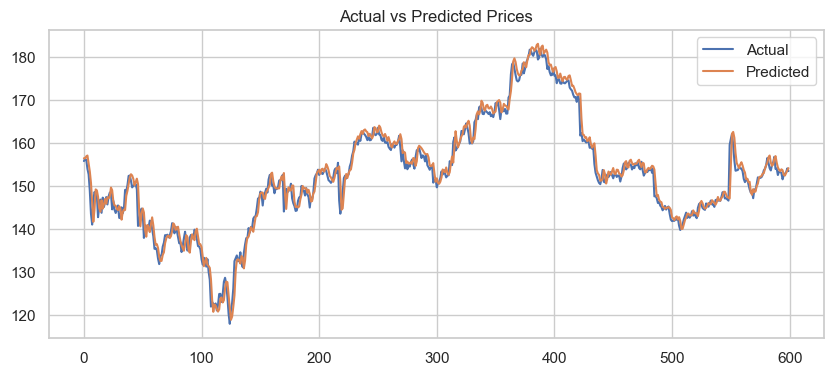

In [177]:
build_evaluate_rnn_model(all_stocks_df, 'IBM', window_size = 20, step_size =1, 
                         train_ratio=0.8, batch_size = 32, epoch_num=20)

### Simple RNN for AMZN

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0277 - val_loss: 0.4123
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 - val_loss: 0.3037
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.2830
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.2192
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.2161
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.2369
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - val_loss: 0.1976
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.1826
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.1783
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.1663
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.1778
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_lo

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,955 (31.08 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,304 (20.72 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0324

Test Loss (MSE): 0.12205154448747635
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
MSE: 0.1221
RMSE: 0.3494
R² Score: 0.7019


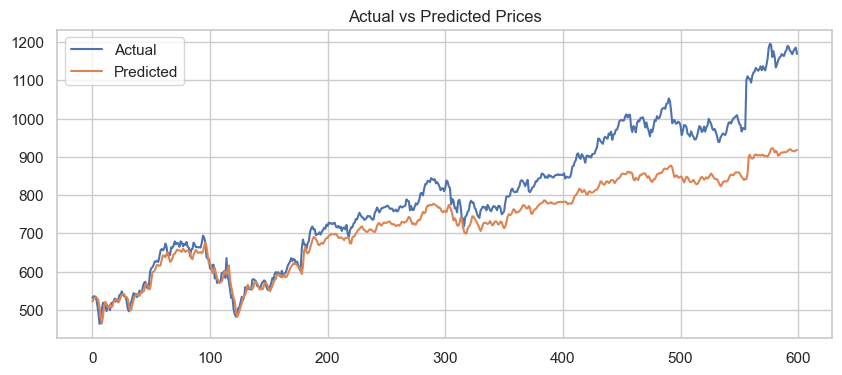

In [182]:
build_evaluate_rnn_model(all_stocks_df, 'AMZN', window_size = 20, step_size =1, 
                         train_ratio=0.8, batch_size = 32, epoch_num=20)

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [76]:
# Find an optimal configuration of simple RNN

def build_simple_rnn_model(hp):
    model = Sequential()

    # RNN Layer
    model.add(SimpleRNN(
        units=hp.Int("rnn_units", min_value=16, max_value=128, step=20),
        activation="tanh",
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))

    # Optional dropout
    if hp.Boolean("use_dropout"):
        model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Optimizer and loss
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss='mse'
    )

    return model


In [77]:
tuner = kt.RandomSearch(
    build_simple_rnn_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="rnn_tuning",
    project_name="simple_rnn"
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Reloading Tuner from rnn_tuning/simple_rnn/tuner0.json


In [78]:
# Find the best configuration based on evaluation metrics
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best RNN units:", best_hp.get('rnn_units'))
print("Best dropout used:", best_hp.get('use_dropout'))
print("Best dropout rate:", best_hp.get('dropout_rate'))
print("Best learning rate:", best_hp.get('learning_rate'))




Best RNN units: 56
Best dropout used: True
Best dropout rate: 0.1
Best learning rate: 0.01


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

###  Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model


### Optimized RNN for MSFT

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0234 - val_loss: 0.2541
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.1738
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.1353
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.1287
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.1101
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0795
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0980
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0544
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0604
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0592
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0453
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_lo

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 56)             │         3,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,917 (38.74 KB)

 Trainable params: 3,305 (12.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,612 (25.83 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077

Test Loss (MSE): 0.025962352752685547
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
MSE: 0.0260
RMSE: 0.1611
R² Score: 0.9514


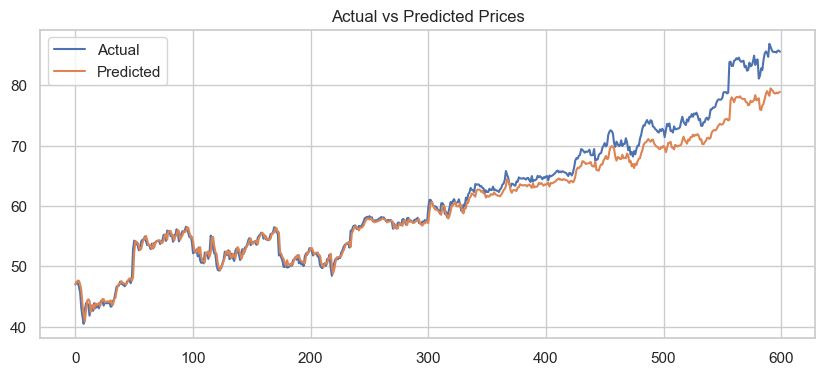

In [192]:
build_evaluate_rnn_model(all_stocks_df, 'MSFT', window_size = 20, step_size =1, 
                         train_ratio=0.8, batch_size = 32, epoch_num=20,
                        rnn_units=56, learning_rate=0.001, dropout_rate =0.1)

### Optimized RNN for AMZN

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0496 - val_loss: 0.4062
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.3045
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 0.2303
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.1889
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.1670
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.1308
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.1140
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.1097
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.1031
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.1026
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0874
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_lo

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_14 (SimpleRNN)       │ (None, 56)             │         3,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,917 (38.74 KB)

 Trainable params: 3,305 (12.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,612 (25.83 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0184

Test Loss (MSE): 0.06445510685443878
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
MSE: 0.0645
RMSE: 0.2539
R² Score: 0.8426


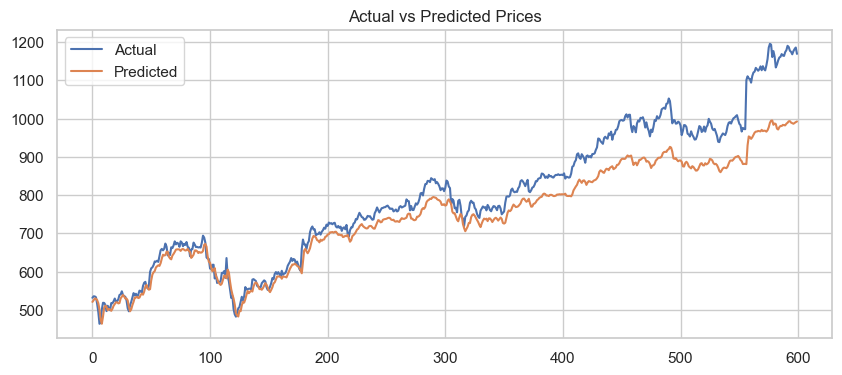

In [222]:
build_evaluate_rnn_model(all_stocks_df, 'AMZN', window_size = 20, step_size =1, 
                         train_ratio=0.8, batch_size = 32, epoch_num=20,
                        rnn_units=56, learning_rate=0.001, dropout_rate =0.1)

### Optimized RNN for GOOGL

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0378 - val_loss: 0.0832
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0663
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0539
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0492
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0391
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0251
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0297
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0299
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0217
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0184
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0115
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_lo

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 56)             │         3,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,917 (38.74 KB)

 Trainable params: 3,305 (12.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,612 (25.83 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037

Test Loss (MSE): 0.007836204953491688
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
MSE: 0.0078
RMSE: 0.0885
R² Score: 0.9653


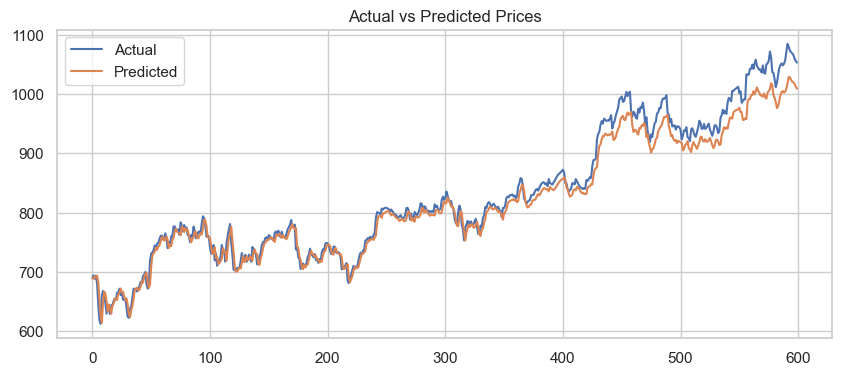

In [210]:
build_evaluate_rnn_model(all_stocks_df, 'GOOGL', window_size = 20, step_size =1, 
                         train_ratio=0.8, batch_size = 32, epoch_num=20,
                        rnn_units=56, learning_rate=0.001, dropout_rate =0.1)

### Optimized RNN for IBM

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2461 - val_loss: 0.0178
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297 - val_loss: 0.0111
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207 - val_loss: 0.0095
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - val_loss: 0.0081
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0072
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0066
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0054
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0056
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - val_loss: 0.0048
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - val_loss: 0.0049
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - val_loss: 0.0043
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 - val_lo

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 56)             │         3,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,917 (38.74 KB)

 Trainable params: 3,305 (12.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,612 (25.83 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043

Test Loss (MSE): 0.0035772856790572405
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
MSE: 0.0036
RMSE: 0.0598
R² Score: 0.9675


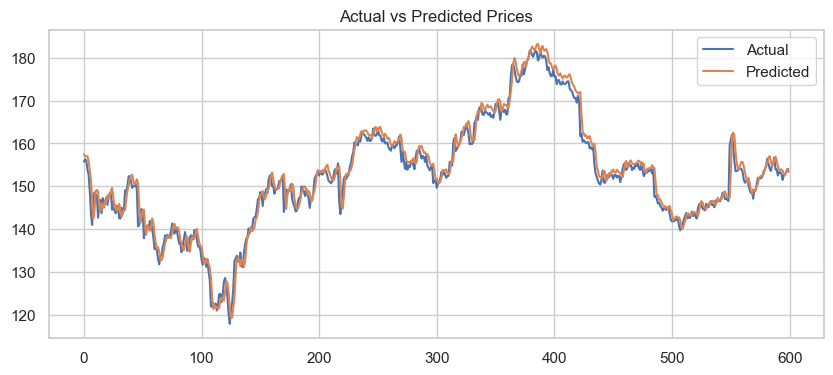

In [212]:
build_evaluate_rnn_model(all_stocks_df, 'IBM', window_size = 20, step_size =1, 
                         train_ratio=0.8, batch_size = 32, epoch_num=20,
                        rnn_units=56, learning_rate=0.001, dropout_rate =0.1)

Plotting the actual vs predicted values

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

### Simple RNN with and without Hyperparameters

||Simple RNN |without Hyperparameter|Simple RNN|with Hyperparameter|
|----------|----------|----------|----------|----------|
| **Stock Names**|**RMSE value** | **R² value** | **RMSE value** | **R² value** |
| GOOGL          | 0.3526        | 0.5310       | 0.0885         | 0.9653       |
| MSFT           | 0.3525        | 0.7675       | 0.1611         | 0.9514       |
| IBM            | 0.0560        | 0.9714       | 0.0598         | 0.9675       |
| AMZN           | 0.3494        | 0.7019       | 0.2539         | 0.8426       |

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [90]:
# # Define a function to create a model and specify default values for hyperparameters

def build_basic_lstm_model(num_layers, lstm_units, window_size, num_features,
                         optional_dense_units = 32, dropout_rate = 0.2, learning_rate =0.01, ):
    model = Sequential()

    for layer_num in range(num_layers):

        if layer_num +1 == num_layers:
            model.add(LSTM(lstm_units, return_sequences=False))  # last LSTM layer, return_sequences=False
        else:
            model.add(LSTM(lstm_units, return_sequences=True, input_shape=(window_size, num_features)))
            
        model.add(Dropout(dropout_rate))


    model.add(Dense(optional_dense_units, activation='relu'))

    # Output layer
    model.add(Dense(1))  # For regression

    # Compile the model
    model.compile(optimizer=Adam(learning_rate), loss='mse')

    return model



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [92]:
# Find an optimal configuration


def build_lstm_model_with_hyperparams(hp):
    """
    Builds an LSTM model with tunable hyperparameters for Keras Tuner.

    """
    model = Sequential()

    # Number of LSTM layers
    num_lstm_layers = hp.Int("num_lstm_layers", min_value=1, max_value=3)

    for i in range(num_lstm_layers):
        return_sequences = i < num_lstm_layers - 1  # Only last layer returns False
        units = hp.Int(f"lstm_units_{i}", min_value=32, max_value=128, step=32)

        if i == 0:
            # First layer needs input shape
            model.add(LSTM(units, return_sequences=return_sequences, input_shape=(window_size, num_features)))
        else:
            model.add(LSTM(units, return_sequences=return_sequences))

        # Optional dropout
        if hp.Boolean(f"use_dropout_{i}"):
            dropout_rate = hp.Float(f"dropout_rate_{i}", 0.1, 0.5, step=0.1)
            model.add(Dropout(dropout_rate))

    # Optional Dense hidden layer
    if hp.Boolean("add_dense_layer"):
        dense_units = hp.Int("dense_units", 32, 128, step=32)
        model.add(Dense(dense_units, activation="relu"))

    # Final output layer for regression
    model.add(Dense(1))

    # Compile with optimizer and learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss="mse")

    return model

In [93]:
# Define your input shape
window_size = X_train.shape[1]
num_features = X_train.shape[2]

# Initialize tuner
tuner = kt.RandomSearch(
    build_lstm_model_with_hyperparams,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="lstm_tuning",
    project_name="lstm_stock_model"
)

# Run the search
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Get the best model
best_model = tuner.get_best_models(1)[0]

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("best num_lstm_layers : ", best_hp.get("num_lstm_layers"))
print("best lstm_units_0 : ", best_hp.get("lstm_units_0"))
print("best lstm_units_1 : ", best_hp.get("lstm_units_1"))
print("best lstm_units_2 : ", best_hp.get("lstm_units_2"))

print("best use_dropout_0 : ", best_hp.get("use_dropout_0"))
print("best use_dropout_1 : ", best_hp.get("use_dropout_1"))
print("best use_dropout_2 : ", best_hp.get("use_dropout_2"))

print("best add_dense_layer : ", best_hp.get("add_dense_layer"))
print("best dense_units : ", best_hp.get("dense_units"))
print("best learning_rate : ", best_hp.get("learning_rate"))



Reloading Tuner from lstm_tuning/lstm_stock_model/tuner0.json
best num_lstm_layers :  3
best lstm_units_0 :  96
best lstm_units_1 :  96
best lstm_units_2 :  128
best use_dropout_0 :  False
best use_dropout_1 :  True
best use_dropout_2 :  True
best add_dense_layer :  True
best dense_units :  64
best learning_rate :  0.01


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [140]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

def build_best_lstm_model(window_size, num_features):
    model = Sequential()

    # Layer 1
    model.add(LSTM(96, return_sequences=True, input_shape=(window_size, num_features)))

    # Layer 2
    model.add(LSTM(96, return_sequences=True, input_shape=(window_size, num_features)))
    model.add(Dropout(0.2))

    # Layer 3
    model.add(LSTM(128, return_sequences=False))  # last LSTM layer, return_sequences=False
    model.add(Dropout(0.2))
    # No dropout after layer 1 since use_dropout_1 = False

    # Optional Dense layer
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(1))  # For regression

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

    return model


def build_evaluate_LSTM_best_model(df, stock_name, window_size = 20, step_size =1, train_ratio=0.8, 
                            batch_size = 32, epoch_num=10):
        
    X_train, y_train, X_test, y_test, X_scaler, y_scaler = prepare_rnn_dataset(
        get_stock_related_columns(all_stocks_df, stock_name),
        [stock_name],
        window_size= window_size,
        step_size=step_size,
        train_ratio=train_ratio
    )
    
    window_size = X_train.shape[1]
    num_features = X_train.shape[2]
    
    lstm_model = build_best_lstm_model(window_size, num_features)
  
    early_stop = EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights = True)
    
    # Train the model
    lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, 
                   batch_size=batch_size, callbacks = [early_stop])
    print('==================================================================================')
    print()

    # Compute the performance of the model on the testing data set
    y_pred_lstm = lstm_model.predict(X_test)
    print_model_evaluation_metrics(lstm_model, X_test, y_test, y_pred_lstm)
    
    plot_actual_vs_predicted(y_test, y_pred_lstm, y_scaler)
    


#### LSTM model for GOOGL

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1476 - val_loss: 0.5106
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0057 - val_loss: 0.1085
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0037 - val_loss: 0.0314
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0055 - val_loss: 0.0157
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0032 - val_loss: 0.0473
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0033 - val_loss: 0.0104
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0035 - val_loss: 0.2244
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0040 - val_loss: 0.0390
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0033 - val_loss: 0.4024
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0025 - val_loss: 0.0165

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 20, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 20, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705,797 (2.69 MB)

 Trainable params: 235,265 (919.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 470,532 (1.79 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0220

Test Loss (MSE): 0.016454672440886497
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE: 0.0165
RMSE: 0.1283
R² Score: 0.9272


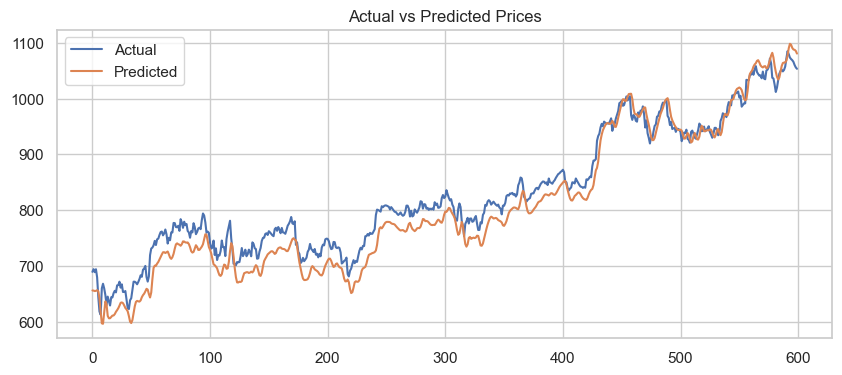

In [152]:
build_evaluate_LSTM_best_model(all_stocks_df, 'GOOGL', window_size = 20, step_size =1, train_ratio=0.8, 
                            batch_size = 32, epoch_num=10)


#### LSTM model for AMZN

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2063 - val_loss: 0.4007
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0040 - val_loss: 0.0722
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0031 - val_loss: 0.3732
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0028 - val_loss: 0.2752
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0026 - val_loss: 0.5169
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0026 - val_loss: 0.7002
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0025 - val_loss: 0.1066
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0022 - val_loss: 0.0560
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0028 - val_loss: 0.0705
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0025 - val_loss: 0.0136

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 20, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 20, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 128)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705,797 (2.69 MB)

 Trainable params: 235,265 (919.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 470,532 (1.79 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144

Test Loss (MSE): 0.013627066276967525
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MSE: 0.0136
RMSE: 0.1167
R² Score: 0.9667


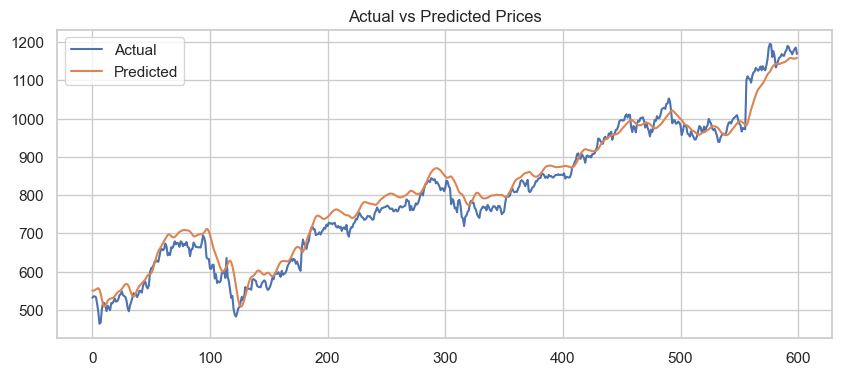

In [153]:
build_evaluate_LSTM_best_model(all_stocks_df, 'AMZN', window_size = 20, step_size =1, train_ratio=0.8, 
                            batch_size = 32, epoch_num=10)

#### LSTM model for IBM

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8135 - val_loss: 0.0200
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0316 - val_loss: 0.0067
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0215 - val_loss: 0.0095
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0167 - val_loss: 0.0068
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0152 - val_loss: 0.0067
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0135 - val_loss: 0.0065
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0132 - val_loss: 0.0103
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0120 - val_loss: 0.0053
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0113 - val_loss: 0.0095
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0120 - val_loss: 0.0054

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 20, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 20, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 20, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 128)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705,797 (2.69 MB)

 Trainable params: 235,265 (919.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 470,532 (1.79 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068

Test Loss (MSE): 0.005437880288809538
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE: 0.0054
RMSE: 0.0737
R² Score: 0.9506


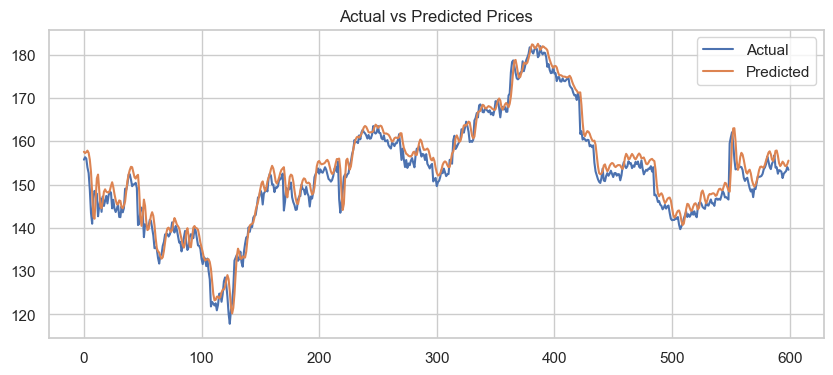

In [156]:
build_evaluate_LSTM_best_model(all_stocks_df, 'IBM', window_size = 20, step_size =1, train_ratio=0.8, 
                            batch_size = 32, epoch_num=10)

#### LSTM model for MSFT

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1208 - val_loss: 0.2587
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0068 - val_loss: 0.0820
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0060 - val_loss: 0.2255
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0053 - val_loss: 0.1695
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0048 - val_loss: 0.0709
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0044 - val_loss: 0.2652
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0039 - val_loss: 0.0970
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0039 - val_loss: 0.1129
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0036 - val_loss: 0.0795
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0042 - val_loss: 0.0233

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 20, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 20, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 20, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 128)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705,797 (2.69 MB)

 Trainable params: 235,265 (919.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 470,532 (1.79 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107

Test Loss (MSE): 0.0233295951038599
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MSE: 0.0233
RMSE: 0.1527
R² Score: 0.9563


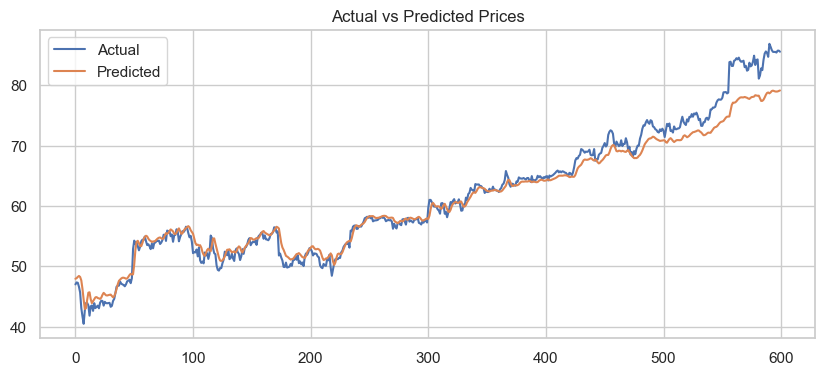

In [154]:
build_evaluate_LSTM_best_model(all_stocks_df, 'MSFT', window_size = 20, step_size =1, train_ratio=0.8, 
                            batch_size = 32, epoch_num=10)

### Optimized LSTM model results:

| Stock Name|RMSE value| R² value|
|----------|----------|----------|
| GOOGL   | 0.1283     | 0.9272     |
| MSFT| 0.152 | 0.9563
|IBM| 0.0737 | 0.9506
|AMZN | 0.1167 | 0.9667


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

**Objective**

The aim of this assignment was to build a predictive model using a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) units to forecast future stock prices. The dataset used consists of historical price and volume data for major technology companies including Amazon, IBM, Microsoft, and Google.

**Data Processing & Model Setup**

The dataset comprised 3020 rows and 21 columns, with complete time-series data. After handling missing values and converting Date columns to datetime objects.A StandardScaler with  windowed DataFrames using partial_fit is applied to avoid data leakage and normalize stock price features for better convergence of the neural network.

The data was split into training and testing sets with an appropriate window size (timesteps) to allow the simple RNN and LSTM models to learn temporal dependencies.


**Model Architecture and Performance**

In the first step, a simple RNN model is built containing one RNN units layer and one dropout layer. Model is applied for all 4 stocks. The R² values for all 4 stocks are inconsistent less than 75%. 

Using the Keras Tuner library, multiple models were built with different Hyperparameters. The RNN model with optimized hyperparameters significantly improved RMSE and R² values for all 4 stocks compared to RNN model without tuning Hyperparameters. 

||Simple RNN |without Hyperparameter|Simple RNN|with Hyperparameter|
|----------|----------|----------|----------|----------|
| **Stock Names**|**RMSE value** | **R² value** | **RMSE value** | **R² value** |
| GOOGL          | 0.3526        | 0.5310       | 0.0885         | 0.9653       |
| MSFT           | 0.3525        | 0.7675       | 0.1611         | 0.9514       |
| IBM            | 0.0560        | 0.9714       | 0.0598         | 0.9675       |
| AMZN           | 0.3494        | 0.7019       | 0.2539         | 0.8426       |


Under Advanced RNN section, LSTM model with optimized hyperparameter has been built. The model used multiple LSTM layers stacked with dropout layers in between to prevent overfitting.The final architecture concluded with a Dense output layer to predict closing prices. The model was compiled using the Adam optimizer and Mean Squared Error (MSE) loss function. Early stopping technique has been used in training RNNs which stops training automatically when the model stops improving on validation data.

Training showed a smooth and consistent decrease in training loss, confirming that the model was learning effectively from the time-series patterns.

| Stock Name|RMSE value| R² value|
|----------|----------|----------|
| GOOGL   | 0.1283     | 0.9272     |
| MSFT| 0.152 | 0.9563
|IBM| 0.0737 | 0.9506
|AMZN | 0.1167 | 0.9667


**Model Prediction Accuracy**

The LSTM model was able to closely follow the actual stock price trends, as seen from the predicted vs. actual price plots. The model successfully captured short-term dependencies and predicted the direction of movement quite accurately. The model may not capture sudden spikes or market shocks, which are common in stock prices but not frequent in training data.



**Key Insights**

LSTM is suitable for financial time series, as it retains memory over long sequences and can learn non-linear relationships in time-dependent data. Normalization of features before feeding into the network was essential to improve training stability and convergence.The choice of timesteps (look-back period) had a significant effect. Shorter windows led to less accurate forecasting, while moderately sized windows gave better generalization.

**Future Improvisation**

Model generalization was reasonable, but it can be further improved using:

a. Hyperparameter tuning via tools like Keras Tuner.</br>
b. Incorporating external features such as macroeconomic indicators, sentiment data, or technical indicators.</br>
c. Trying alternative or hybrid models like GRU, CNN-LSTM, or Transformer-based time series models.
